In [1]:
import datamule as dm
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import plotly.graph_objects as go

In [2]:
indexer = dm.Indexer()

indexer.run()

data\metadata.json: 100%|██████████| 59.0/59.0 [00:00<?, ?iB/s]
data\company_tickers.csv: 398kiB [00:00, 2.73MiB/s]
data\submissions_index.csv: 961MiB [00:20, 49.8MiB/s] 


In [3]:
# Takes 14 seconds to run
df = pd.read_csv('data/submissions_index.csv')
df_8k = df[df['form'] == '8-K']
del df

In [4]:
# Inspect data
df_8k.head()

,accession_number,filing_date,primary_doc_url,form,cik
139,0001193125-24-199396,2024-08-13,d864520d8k.htm,8-K,1827087
141,0001193125-24-183318,2024-07-24,d875446d8k.htm,8-K,1827087
142,0001193125-24-180727,2024-07-18,d870519d8k.htm,8-K,1827087
143,0001193125-24-170520,2024-06-27,d792733d8k.htm,8-K,1827087
151,0001193125-24-156044,2024-06-06,d675020d8k.htm,8-K,1827087


In [18]:
# Subset by accession_numbers which have more than one cik
joint_filers_df = df_8k[df_8k.groupby('accession_number')['cik'].transform('nunique') > 1]
joint_filers_df.head()
joint_filers_df.shape

(15630, 5)

In [23]:
# Load company tickers
tickers = pd.read_csv('data/company_tickers.csv')
unique_tickers = tickers.drop_duplicates(subset='cik', keep='first')

# Merge with joint_filers by CIK
joint_filers_tickers = joint_filers_df.merge(unique_tickers, on='cik', how='left')

# Display the first few rows of the merged dataframe
print(joint_filers_tickers.head())

# Display the shape of the merged dataframe
print(joint_filers_tickers.shape)

# number of unique ciks
print(joint_filers_tickers['cik'].nunique())

       accession_number filing_date      primary_doc_url form     cik ticker  \
0  0001104659-24-082494  2024-07-25  tm2420031d1_8-k.htm  8-K  811156    CMS   
1  0001104659-24-058008  2024-05-07   tm2413710d1_8k.htm  8-K  811156    CMS   
2  0001104659-24-051509  2024-04-25   tm2412653d1_8k.htm  8-K  811156    CMS   
3  0001104659-24-009113  2024-02-01    tm244795d1_8k.htm  8-K  811156    CMS   
4  0001104659-23-122055  2023-11-29   tm2331708d1_8k.htm  8-K  811156    CMS   

             title  
0  CMS ENERGY CORP  
1  CMS ENERGY CORP  
2  CMS ENERGY CORP  
3  CMS ENERGY CORP  
4  CMS ENERGY CORP  
(15630, 7)
49


C:\Users\jgfri\AppData\Local\Temp\ipykernel_16764\815276929.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


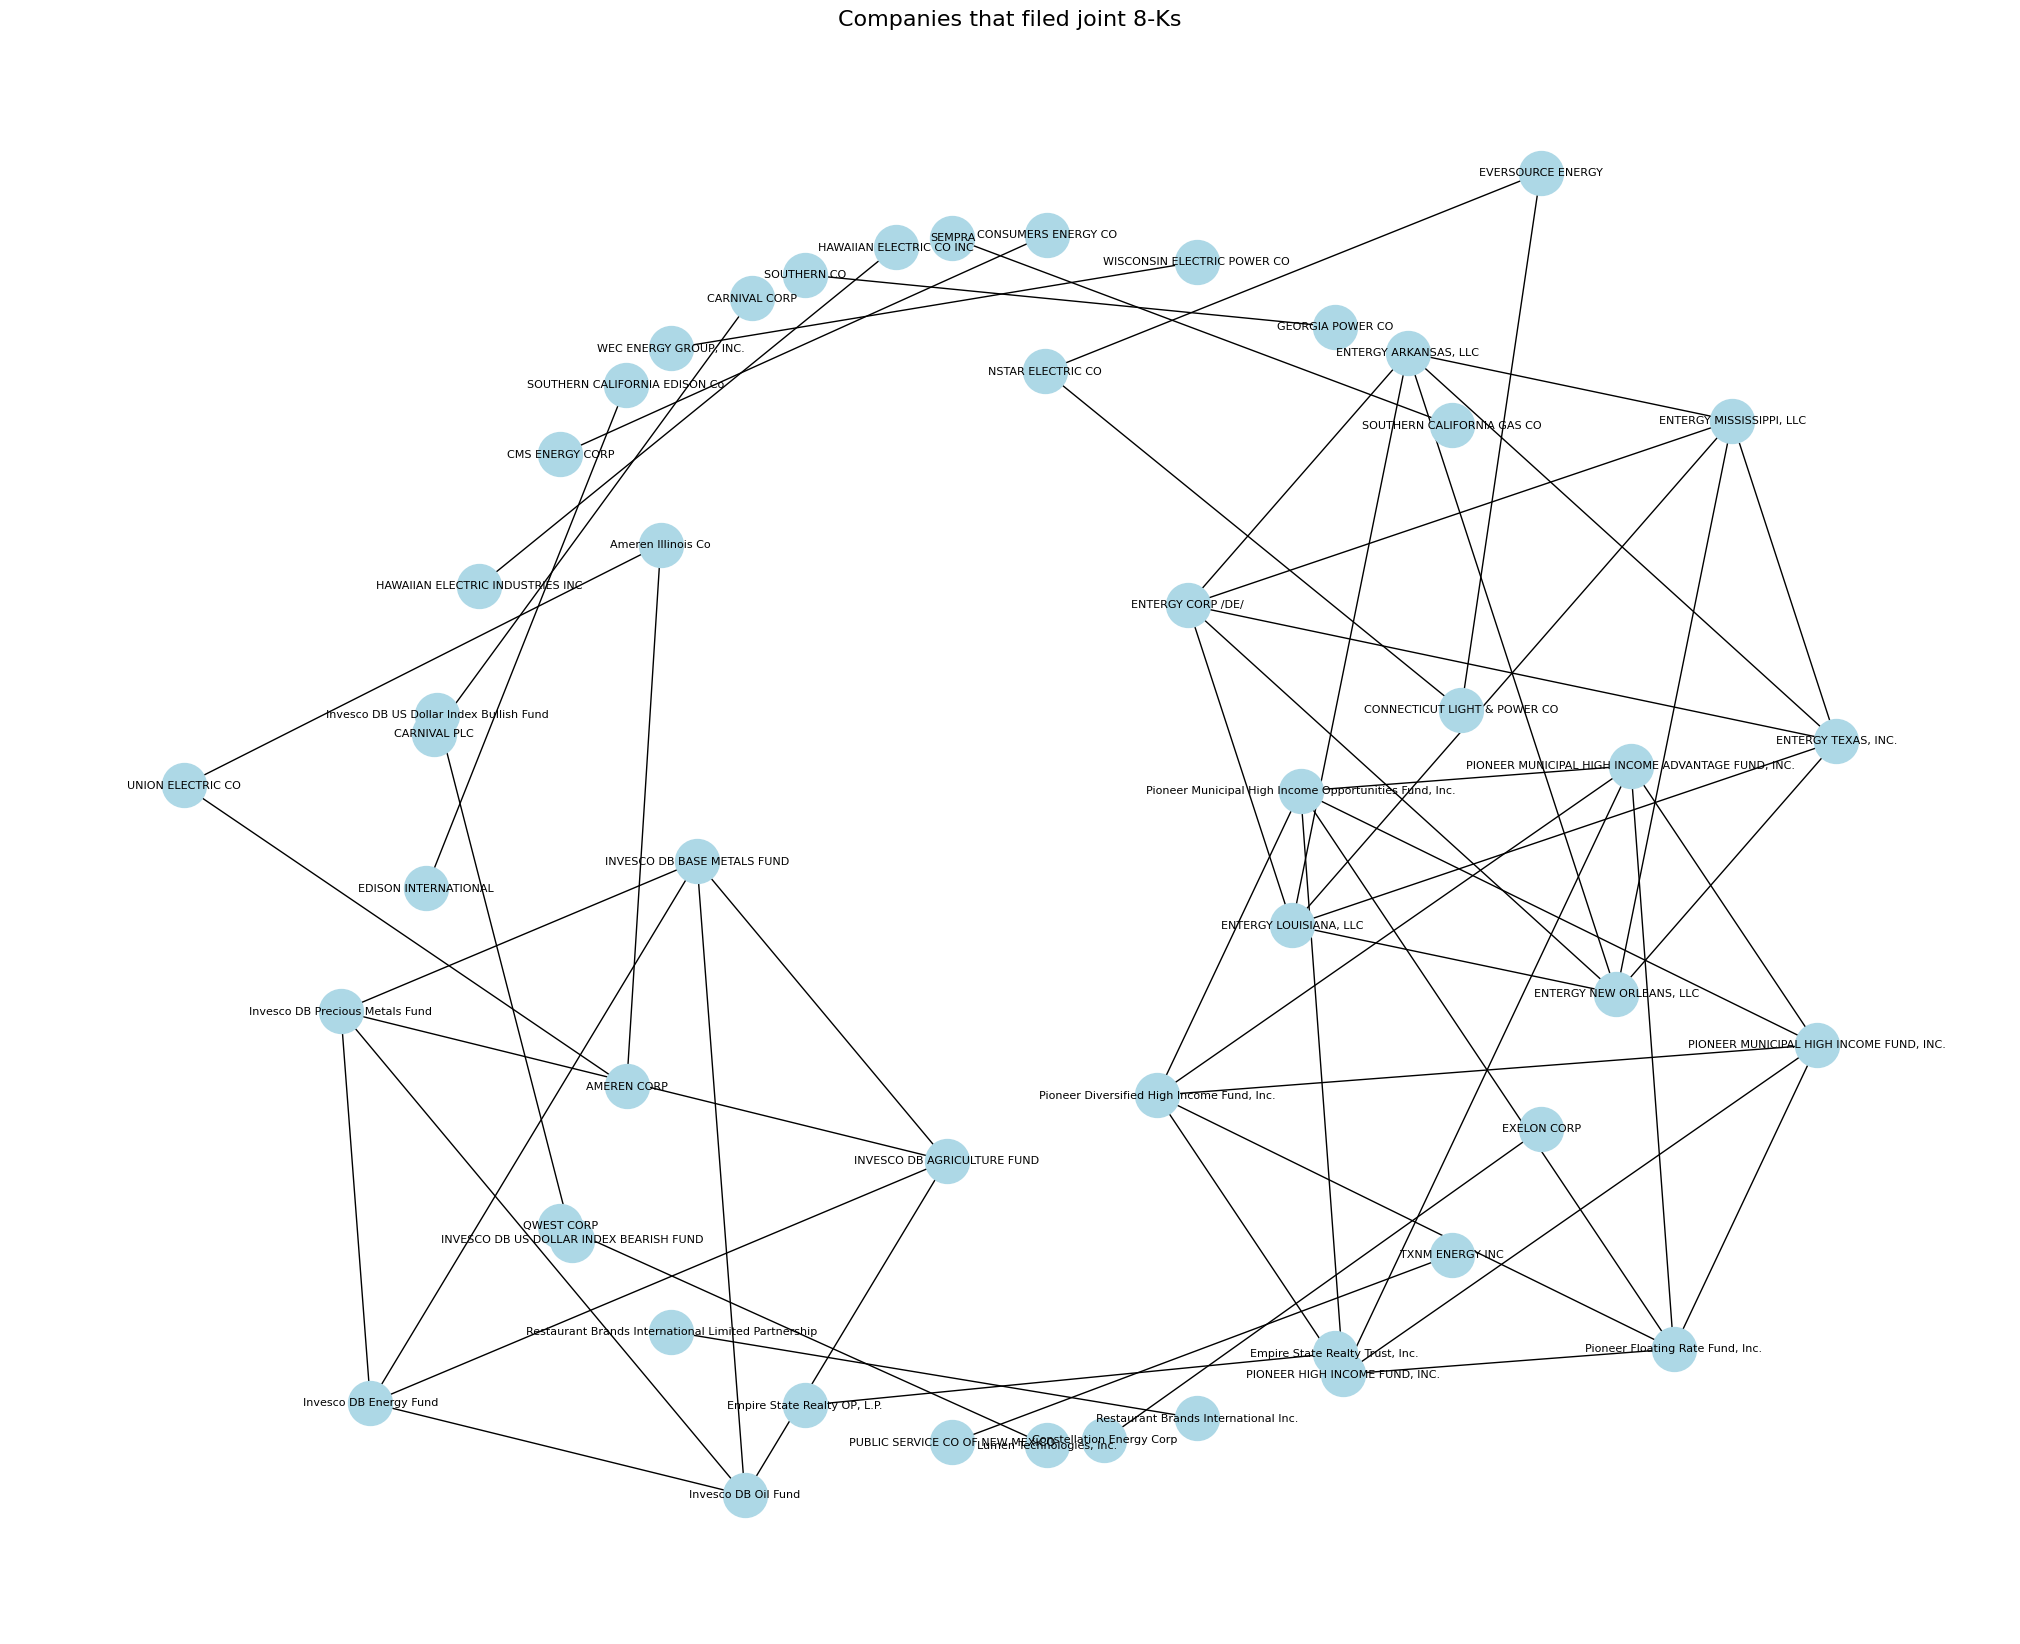

Number of nodes (CIKs): 49
Number of edges (connections): 59
Network density: 0.0502
Most connected CIK: ENTERGY LOUISIANA, LLC with 5 connections
Number of clusters: 18
Sizes of the 5 largest clusters:
  Cluster 1: 6 CIKs
  Cluster 2: 6 CIKs
  Cluster 3: 5 CIKs
  Cluster 4: 3 CIKs
  Cluster 5: 3 CIKs


In [22]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

connections = defaultdict(set)

# Populate the connections dictionary
for _, group in joint_filers_tickers.groupby('accession_number'):
    titles = group['title'].unique()
    for title in titles:
        connections[title].update(set(titles) - {title})

# Create a graph
G = nx.Graph(connections)

# Draw the graph
plt.figure(figsize=(20, 16))  # Increased figure size
pos = nx.kamada_kawai_layout(G)  # Using Kamada-Kawai layout for better spacing
nx.draw(G, pos, node_color='lightblue', 
        node_size=1000,  # Reduced node size
        with_labels=False)  # We'll add labels separately

# Add node labels
for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=8, ha='center', va='center')

# Add a title
plt.title("Companies that filed joint 8-Ks", fontsize=16)

# Show the plot
plt.axis('off')
plt.tight_layout()
plt.show()

# Print some basic network statistics
print(f"Number of nodes (CIKs): {G.number_of_nodes()}")
print(f"Number of edges (connections): {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.4f}")

# Find the CIK with the most connections
most_connected = max(G.degree, key=lambda x: x[1])
print(f"Most connected CIK: {most_connected[0]} with {most_connected[1]} connections")

# Identify clusters (connected components)
clusters = list(nx.connected_components(G))
print(f"Number of clusters: {len(clusters)}")
print("Sizes of the 5 largest clusters:")
for i, cluster in enumerate(sorted(clusters, key=len, reverse=True)[:5], 1):
    print(f"  Cluster {i}: {len(cluster)} CIKs")